## ENSEMBLE TRANSFORMATION

The goal of this notebook is to explain what the Ensemble Transformation does and how it adds uncertainty awareness to neural networks. 
 

## BRIEF INTRODUCTION TO ENSEMBLE TRANSFORMATION 

Before diving into the code, it is important to understand what this type of transformation does and how it helps us handle uncertainty when training a model.  

First of all, what does *ensemble* mean?  
The word *ensemble* refers to a group of elements that are considered together as a whole rather than individually.  
In machine learning, an ensemble is a group of models that learn the same task independently.  

By combining their predictions, the overall model becomes more reliable and can also estimate how confident it is about each prediction that it does.This is because the same input is evaluated by several independently trained models, allowing the system to recognize when the models agree or disagree. 

In the following sections , we will see the demonstration on how this transformation combines multiple independently trained models to improve prediction reliability and to measure how confident the model is about its predictions.


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from torch.distributions import Dirichlet

from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


## DEFINE A SIMPLE MODEL AND DATA SET

In [ ]:

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)




In this part, we first defined a very simple neural network called `SimpleNN`.  
It is a class which consists of two fully connected layers (`Linear`) with a ReLU activation function in between. We have also used (`Forward`) which shows how data flows through the network. 
The model takes two input features and outputs two values, one for each class in our dataset.  

We then created a small 2D classofication problem that is nice to plot using the `make_moons()` function.   

Finally, we split the data into training(80%) and testing(20%) sets and converted them into PyTorch tensors, which are the data structures that PyTorch uses for neural networks.


## CREATE THE ENSEMBLE AND TRAIN IT 

Here, we will call the probly ensemble transformation which takes the base model (SimpleNN) and makes 3 independent copies of it.
So now we don’t have 1 model, but rather 3 models stored together.

As for the training part, each model in the ensemble will get its own optimizer, because at this point they are training separately.
We will be training for 50 epochs (each one of them one by one) using CrossEntropyLoss.

In [ ]:
def ensemble(model_class, num_members=3):
    return [model_class() for _ in range(num_members)]

		
ensemble_model = ensemble(SimpleNN, num_members=3)
ensemble_model

optimizers = [Adam(member.parameters(), lr=0.01) for member in ensemble_model]
criterion = nn.CrossEntropyLoss()
num_epochs = 50

for epoch in range(num_epochs):
    for idx, model in enumerate(ensemble_model):
        model.train()
        optimizers[idx].zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizers[idx].step()

## EVALUATING THE ENSEMBLE

In [ ]:
for member in ensemble_model:
    member.eval()

samples = torch.stack([member(X_test_tensor) for member in ensemble_model], dim=0).permute(1, 0, 2)

_, predicted = torch.max(samples.mean(dim=1), 1)
accuracy = (predicted == y_test_tensor).float().mean().item()
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 89.00%


Here, it puts all models in eval mode (no dropout, etc.) and it also makes each model predict on the test set.
Through torch.max(..., 1) it picks the class with highest probability, compares to true labels to get accuracy and this shows clearly that *combining models gives a stable prediction.*

## DECISION BOUNDARY VISUALISATION

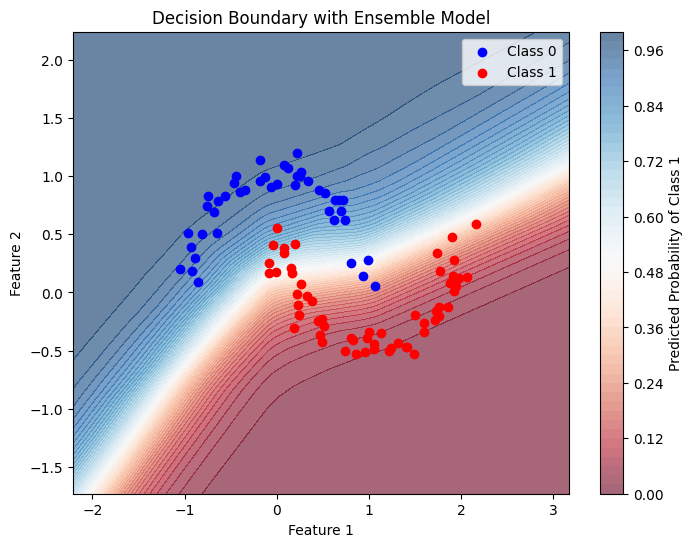

In [ ]:

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x = torch.linspace(x_min, x_max, 100)
y = torch.linspace(y_min, y_max, 100)
xx, yy = torch.meshgrid(x, y, indexing='xy')
grid = torch.cat([xx.unsqueeze(-1), yy.unsqueeze(-1)], dim=-1).view(-1, 2)

for m in ensemble_model:
    m.eval()

with torch.no_grad():
    grid_samples = torch.stack([m(grid) for m in ensemble_model], dim=0).permute(1, 0, 2)
    grid_preds = grid_samples.mean(dim=1)
    probs = torch.softmax(grid_preds, dim=-1)[:, 0].view(xx.shape)


probs_np = np.array(probs.cpu().tolist())
xx_np = np.array(xx.cpu().tolist())
yy_np = np.array(yy.cpu().tolist())

plt.figure(figsize=(8, 6))
plt.contourf(xx_np, yy_np, probs_np, levels=50, cmap='RdBu', alpha=0.6)
plt.colorbar(label='Predicted Probability of Class 1')

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='red', label='Class 1')

plt.title('Decision Boundary with Ensemble Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()





In this part, we create a grid that covers the entire input space and uses the trained ensemble to predict a class probability for every point in that grid.  
This allows us to visualize how the ensemble model divides the space into different classes.  

Each point on the contour plot represents the predicted probability of belonging to a specific class (here, Class 1).  
The red and blue regions show the areas where the model is confident about each class, while the boundary in between represents the uncertain region where the model is less sure.  
The scatter points correspond to the real test samples used for evaluation.


## PLOTTING UNCERTAINITY METRICS

In [ ]:

def TU(probs):
    mean_prob = probs.mean(dim=1)                         
    entropy = -torch.sum(mean_prob * torch.log(mean_prob + 1e-12), dim=-1)
    return entropy.cpu().tolist()                          

def AU(probs):
    entropies = -torch.sum(probs * torch.log(probs + 1e-12), dim=-1)  
    expected_entropy = entropies.mean(dim=1)                           
    return expected_entropy.cpu().tolist()

def EU(probs):
    tu = np.array(TU(probs))
    au = np.array(AU(probs))
    return (tu - au).tolist()


RuntimeError: Numpy is not available

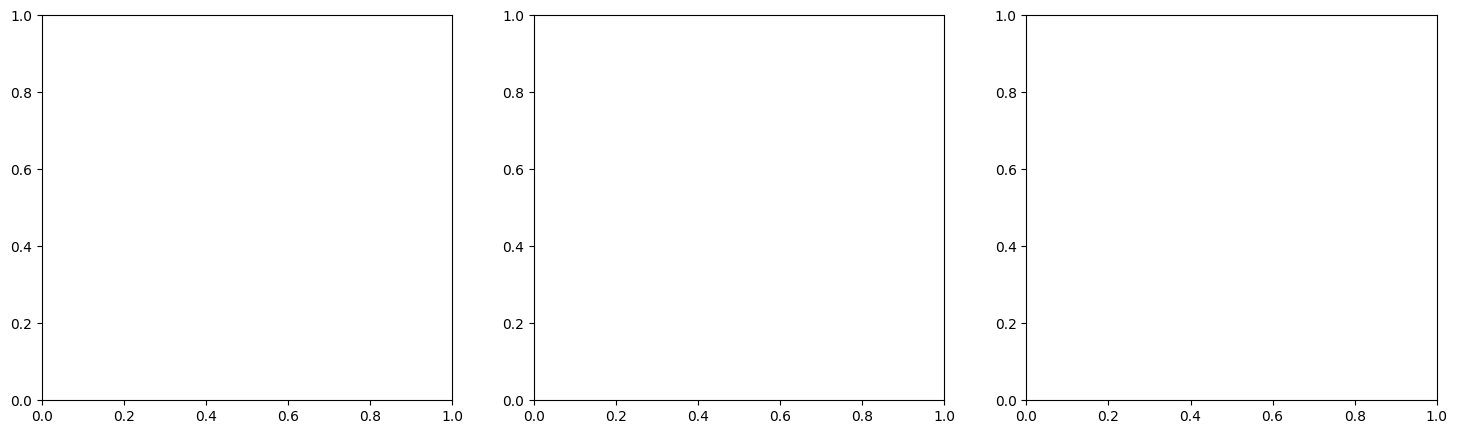

In [ ]:

grid_probs = torch.softmax(grid_samples, dim=-1)  


tu_values = np.array(TU(grid_probs))
au_values = np.array(AU(grid_probs))
eu_values = np.array(EU(grid_probs))


xx_np = np.array(xx.cpu().tolist())
yy_np = np.array(yy.cpu().tolist())


tu_grid = tu_values.reshape(xx_np.shape)
au_grid = au_values.reshape(xx_np.shape)
eu_grid = eu_values.reshape(xx_np.shape)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].contourf(xx_np, yy_np, tu_grid, levels=50, cmap='viridis')
axes[0].set_title('Total Uncertainty')

axes[1].contourf(xx_np, yy_np, au_grid, levels=50, cmap='viridis')
axes[1].set_title('Aleatoric Uncertainty')

axes[2].contourf(xx_np, yy_np, eu_grid, levels=50, cmap='viridis')
axes[2].set_title('Epistemic Uncertainty')

for ax in axes:
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='blue', s=5, zorder=5)
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', s=5, zorder=5)

plt.show()


### Uncertainty Visualization

Here, we compute three types of uncertainty metrics for every point in the grid:
- **Total Uncertainty (TU):** overall uncertainty in the model’s predictions.  
- **Aleatoric Uncertainty (AU):** uncertainty caused by noise or overlap in the data itself.  
- **Epistemic Uncertainty (EU):** uncertainty that comes from limited knowledge or model disagreement.

By plotting these values, we can see which regions of the input space are more uncertain.  
High epistemic uncertainty usually appears in areas far from the training data, while high aleatoric uncertainty occurs where the two classes overlap.  
These visualizations demonstrate how the ensemble transformation adds uncertainty awareness to an otherwise deterministic neural network.


## SUMMARY

The Ensemble Transformation creates multiple versions of the same model and trains them independently.  
By comparing their predictions, we can estimate how confident the system is in different regions of the input space.  
This makes the model both more reliable and more transparent in how it handles uncertainty.
